In [1]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl
%pip install folium

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic


#init project
from models.components import Tech
from models.consumption import Energetic
from models.inventory import Building, Project
import pandas as pd

In [3]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Address and general info🌎

## Energy Consumptions🔌

In [4]:
#cspell:disable


project:Project = Project(
    title='Sistema Fotovoltaico OnGrid-Mixto',
    building = Building(
        geolocation=(-33.613019, -71.444142),
        name='PSR Leyda',
        address='Camino Antiguo S.A. , Sector Leyda,\nSan Antonio',
        city='San Antonio'),
    technology= [Tech.PHOTOVOLTAIC],
    consumption= {
        'description':'main',
        'energetic':Energetic.ELI,
        'cost_increment':7/100,
        'consumption':[
            (344,"02-06-2024",61388),
            (266,"02-05-2024",43945),
            (204,"02-04-2024",34033),
            (179,"02-03-2024",30033),
            (156,"03-02-2024",26400),
            (160,"01-01-2024",26643),
            (229,"02-12-2023",37242),
            (210,"03-11-2023",34257),
            (304,"02-10-2023",48940),
            (211,"02-09-2023",34392),
            (308,"01-08-2023",49558),
            (308,"01-07-2023",59950),
            ],
        }
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.613019&longitude=-71.444142&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$39.70 
set $1 UTM............ on USD$69.68 
set $1 Euro........... on USD$1.09 
set $1 Pound.......... on USD$1.29 
set $1 Real........... on USD$0.18 
adding consumptions data...


# Integration 

## Machine Components 🎡

In [5]:
#cspell: disable

#clean previous load
project.components = {}
from IPython.display import clear_output

from models.energy_storage import Battery
from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Módulo Primario FV A',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=5,
                cost=Cost(208437,Currency.CLP),
                orientation=Orientation(34,103),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    Photovoltaic(project.weather,'Módulo Secundario FV B',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel 650W 48V',
                quantity=5,
                cost=Cost(208437,Currency.CLP),
                orientation=Orientation(34,283),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    generator=True
    )

project.add_component(
    'auxiliar',
    Component('Inversor Híbrido',
                model='Voltronic 5kW 48V',
                reference='https://solarbex.com/comprar/inversor-hibrido-5kw-48v-axpert/',
                specification='Híbrido 5kW Monofásico',
                cost_per_unit=Cost(869,Currency.EUR)),
    Component('Controlador de Carga',
                model='Enertik 80A 12/24V',
                specification='1000W to 2000 24V output',
                cost_per_unit=Cost(101600,Currency.CLP)),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    Battery('almacenamiento',
                model='MP GEL12-250',
                reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-250ah.html',
                cost_per_unit=Cost(305990,Currency.CLP),
                volt=12,
                charge=250,
                demand=project.building.consumption_forecast(['main'])['energy'].to_list(),
                hours_autonomy=5,
                use_regime='8/7',
                )
    )

project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(1,currency=Currency.UF),
            quantity=8*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=8*4
            )
)


inside cost pv :  208437 Currency.CLP
inside cost pv :  208437 Currency.CLP


# Write Document 📒


In [6]:
import os
PATH = 'build/'+f'r_{project.building.city.lower()[:3]}_{project.building.name}/'

if not os.path.exists(PATH):
    #create
    os.makedirs(PATH)

### Saving results on EXCEL ❎

In [7]:
from models.plotter import toTable
toTable(project,PATH)

### Generate Context->Doc📄✍️

In [8]:
from docxtpl import DocxTemplate # type: ignore
#init doc
#assembly proxy object 
memory_report = DocxTemplate("templates/memory_template.docx")
bidding_report = DocxTemplate("templates/bidding_template.docx")

## Write params and tables

In [17]:
#loading context
#cspell: disable
memory_report.render(project.context(template=memory_report))
bidding_report.render(project.context(template=bidding_report))


## Insert Plots 📊

In [19]:
project.context(template=memory_report)

{'report_date': 'Wed, 24 de July 2024',
 'report_version': 'ver.eafd78dc',
 'project': <models.inventory.Project at 0x21d0d948050>,
 'gmaps': <docxtpl.richtext.RichText at 0x21d315f7560>,
 'project_type': 'Fotovoltaico',
 'project_size': '6.55 kW',
 'total_cost': 'CLP$ 6,599,600',
 'annual_benefits': 'CLP$ 494,885',
 'energy_production': '3667 kWh/año',
 'energy_netbilling': '1358 kWh/año',
 'energy_savings': '2309 kWh/año',
 'emission_reduction': '747.25 kg CO2',
 'emission_forecast': '0.2378 Ton CO2/MWh',
 'table_emission_historic': '|   year |   emission |\n|-------:|-----------:|\n|   2018 |     0.4187 |\n|   2019 |     0.4056 |\n|   2020 |     0.3834 |\n|   2021 |     0.3907 |\n|   2022 |     0.3006 |\n|   2023 |     0.2421 |',
 'table_emission_reduction': '|   mes |   CO2 kg |\n|------:|---------:|\n|     1 |   100.43 |\n|     2 |    82.09 |\n|     3 |    73.12 |\n|     4 |    49.38 |\n|     5 |    34.89 |\n|     6 |    28.37 |\n|     7 |    31.32 |\n|     8 |    39.05 |\n|     9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot_done


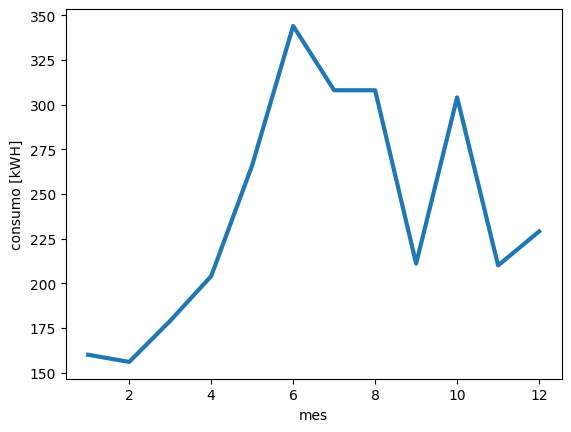

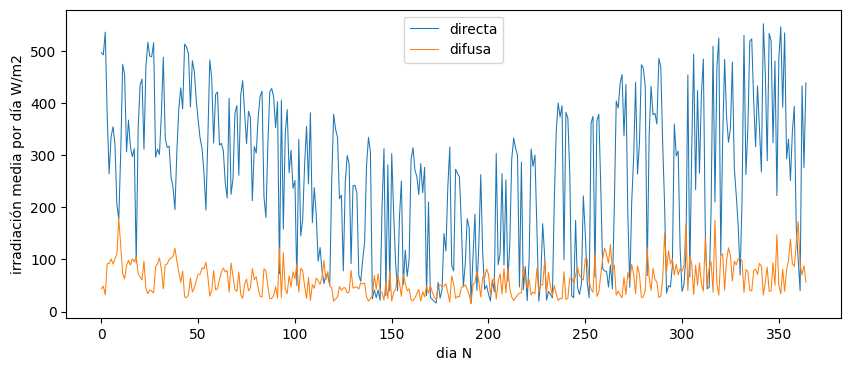

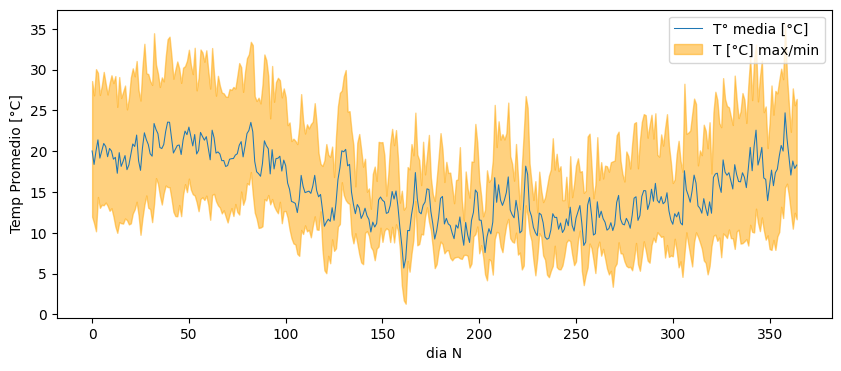

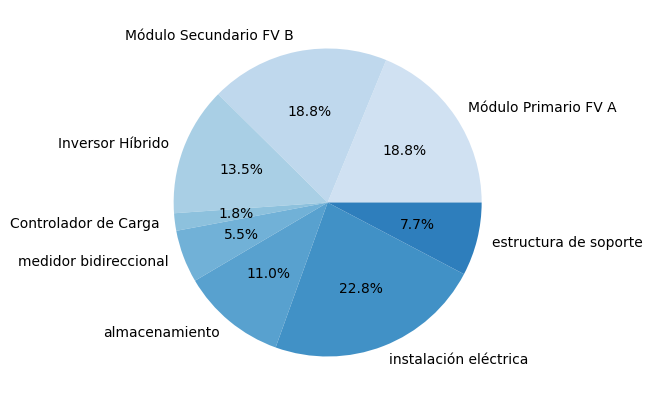

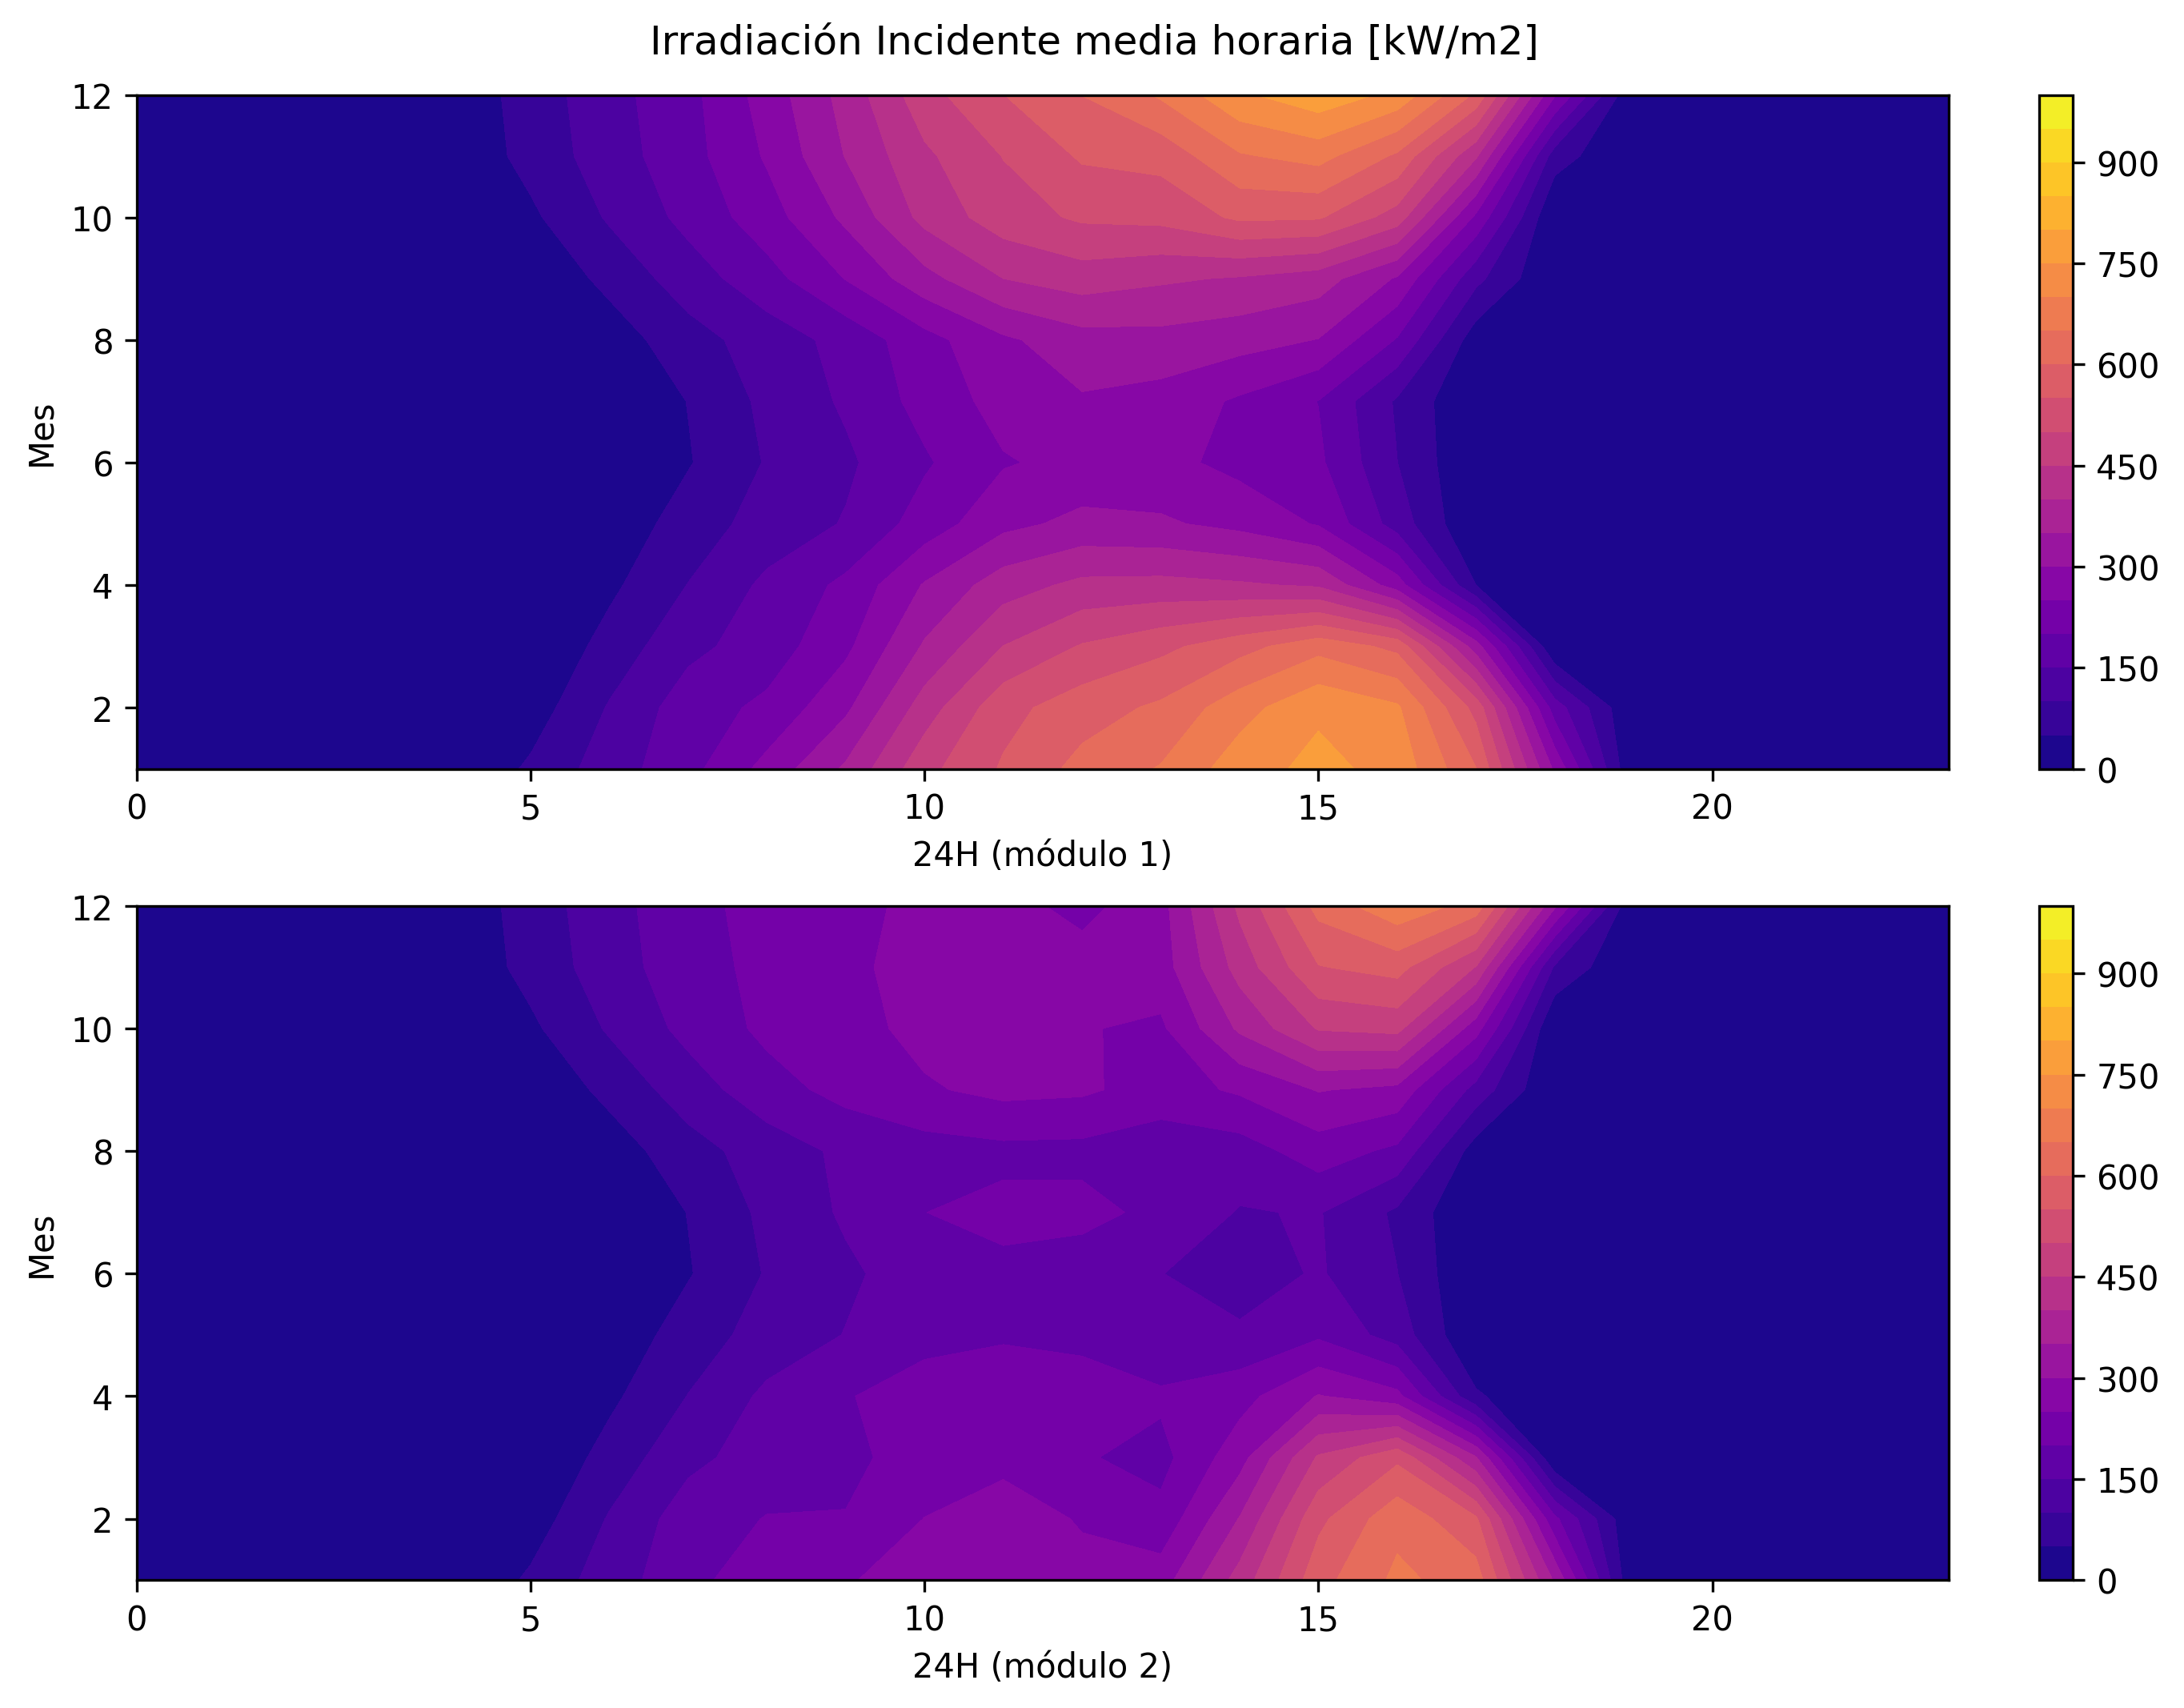

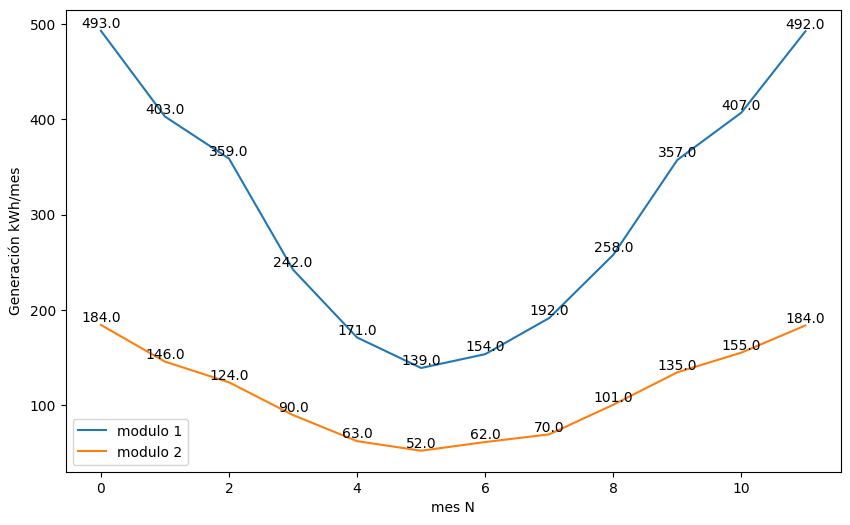

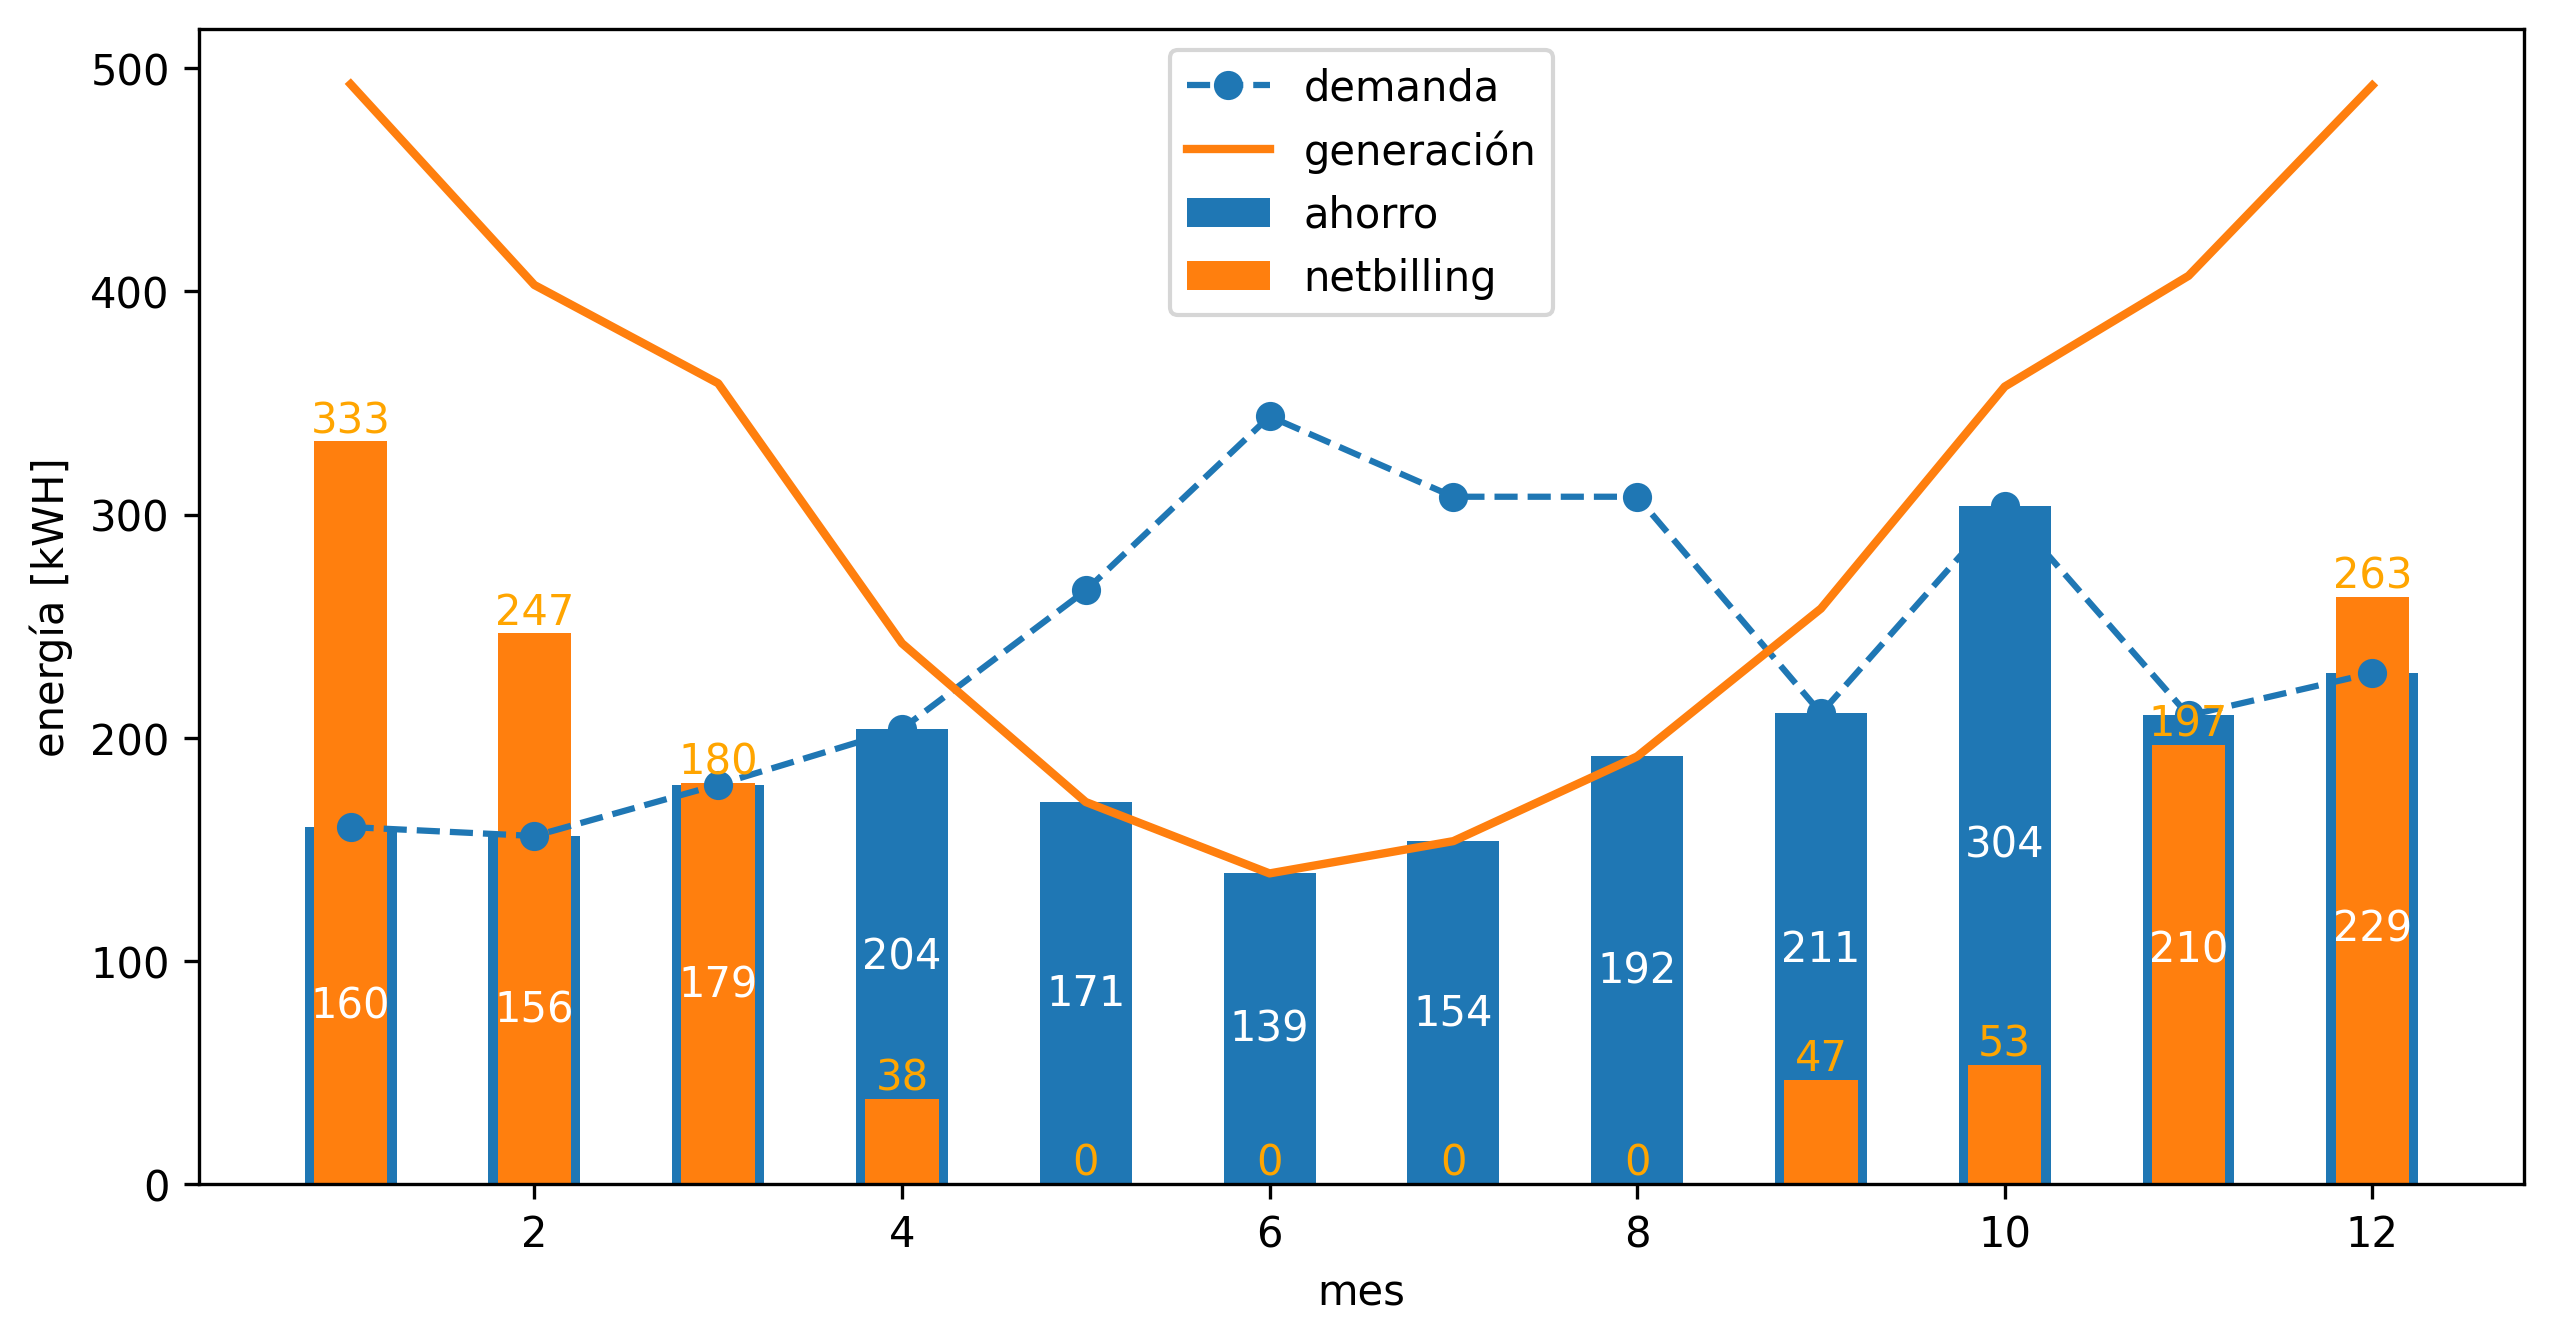

<Figure size 1920x1440 with 0 Axes>

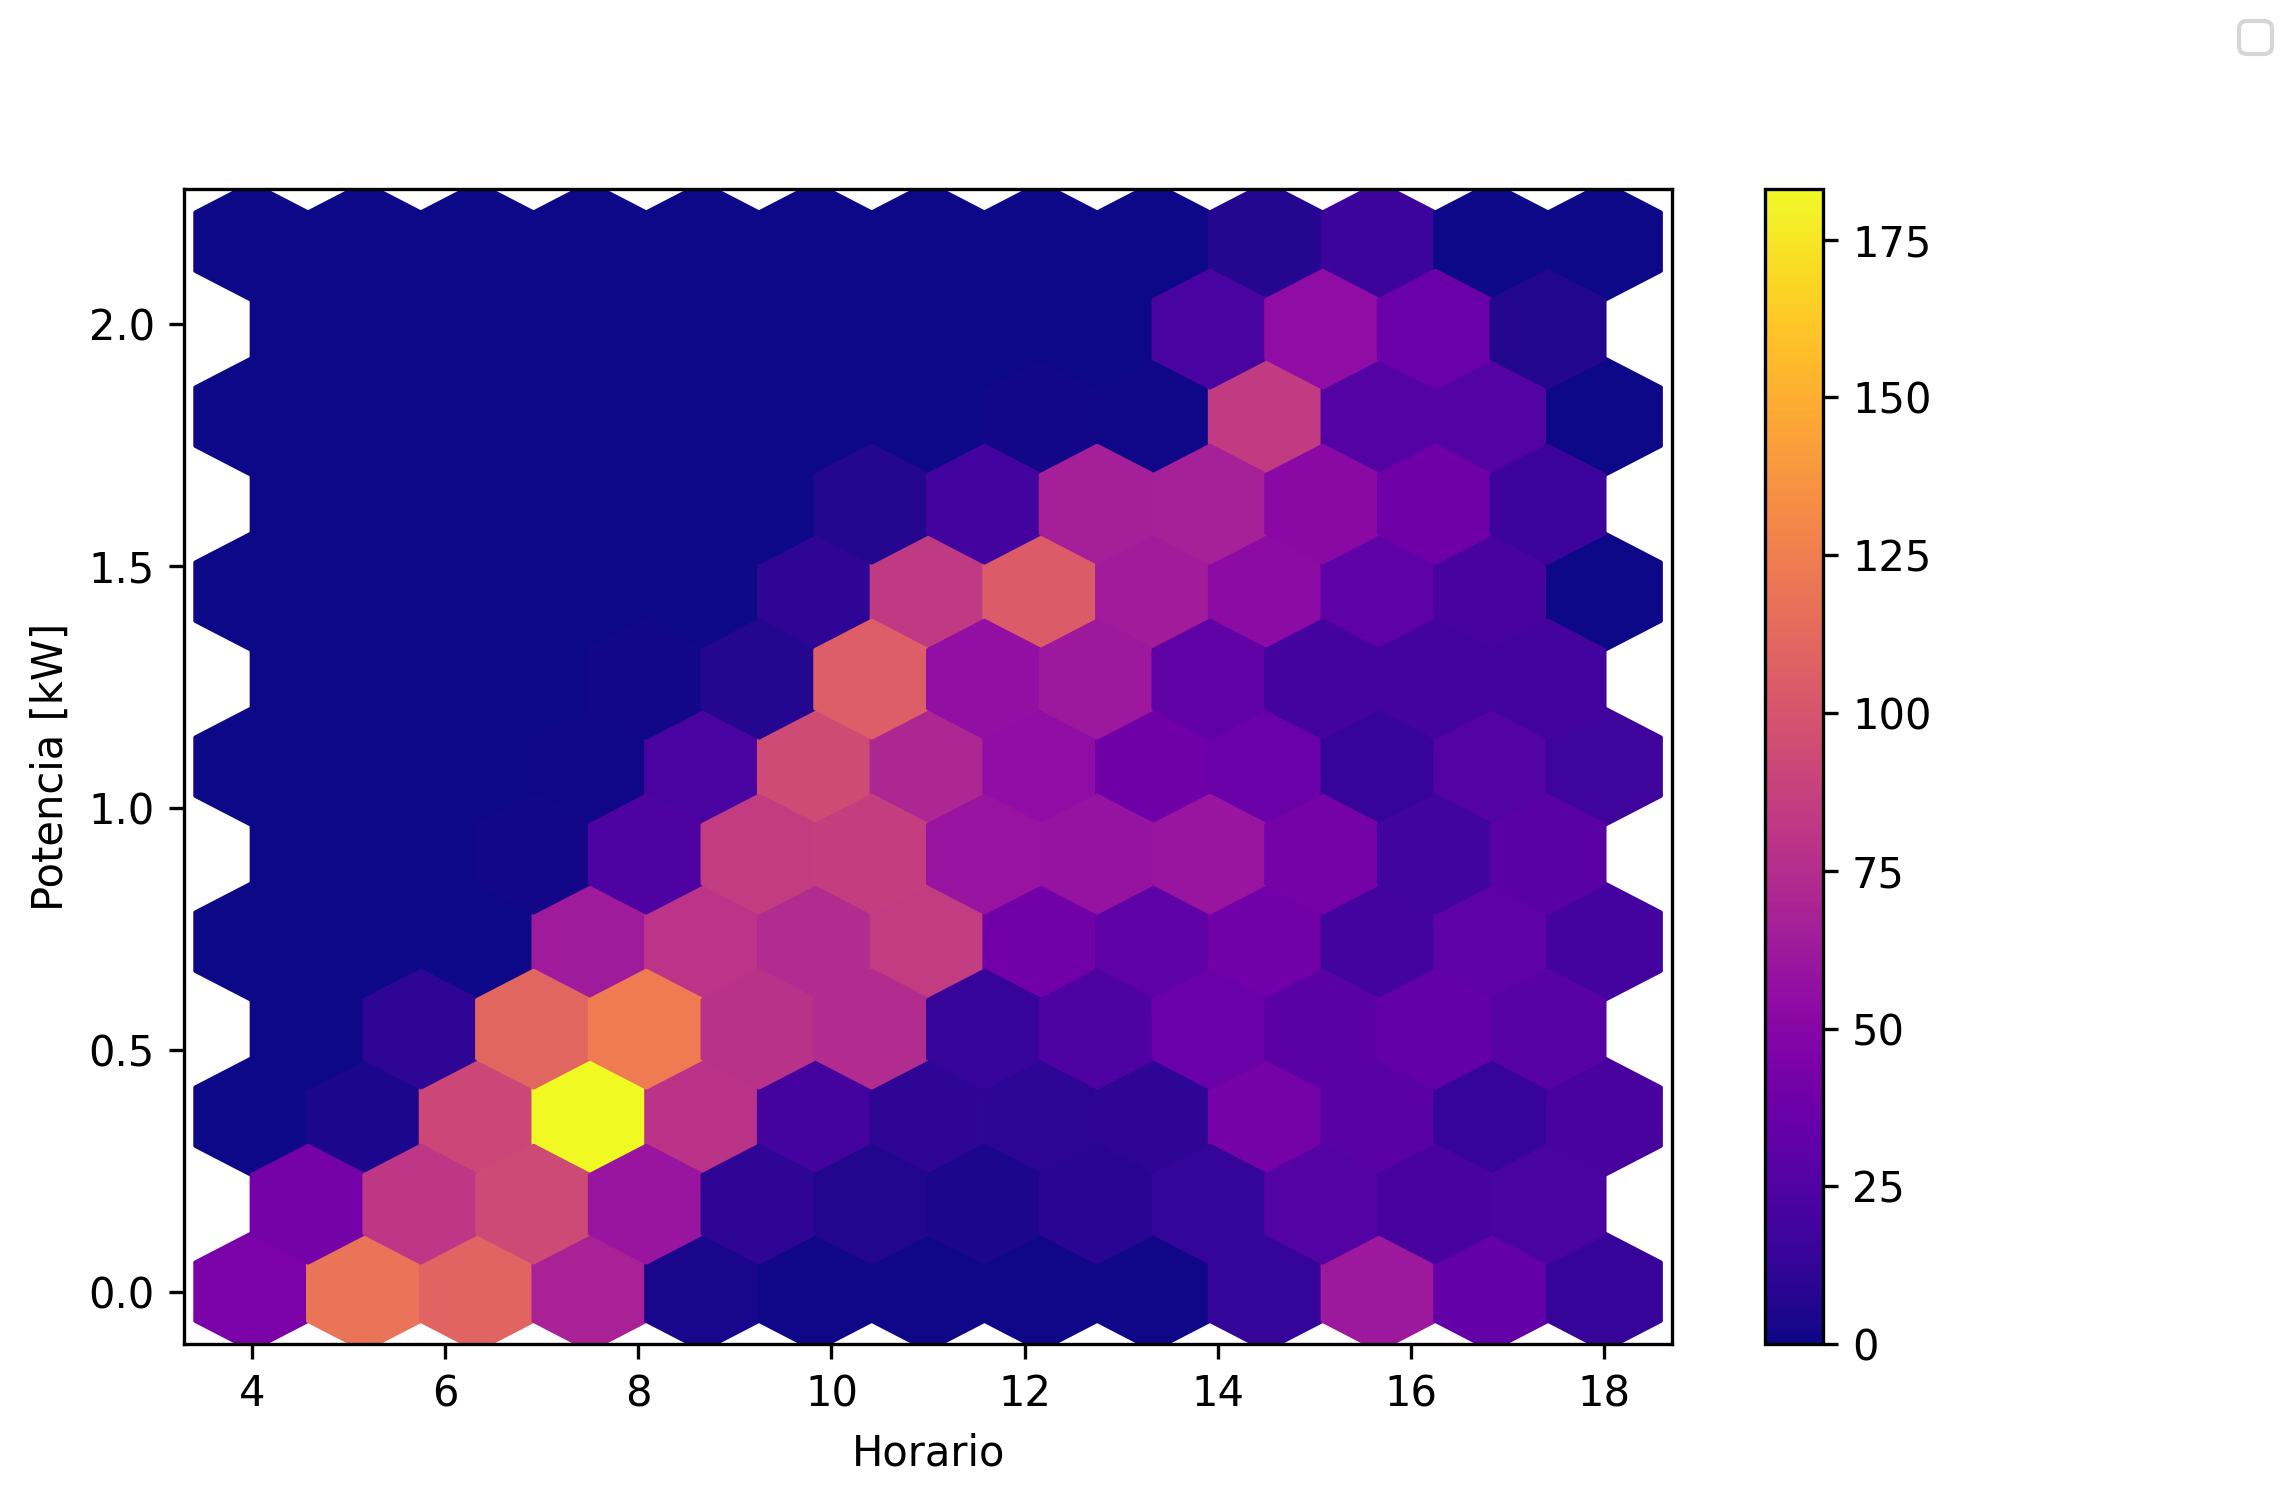

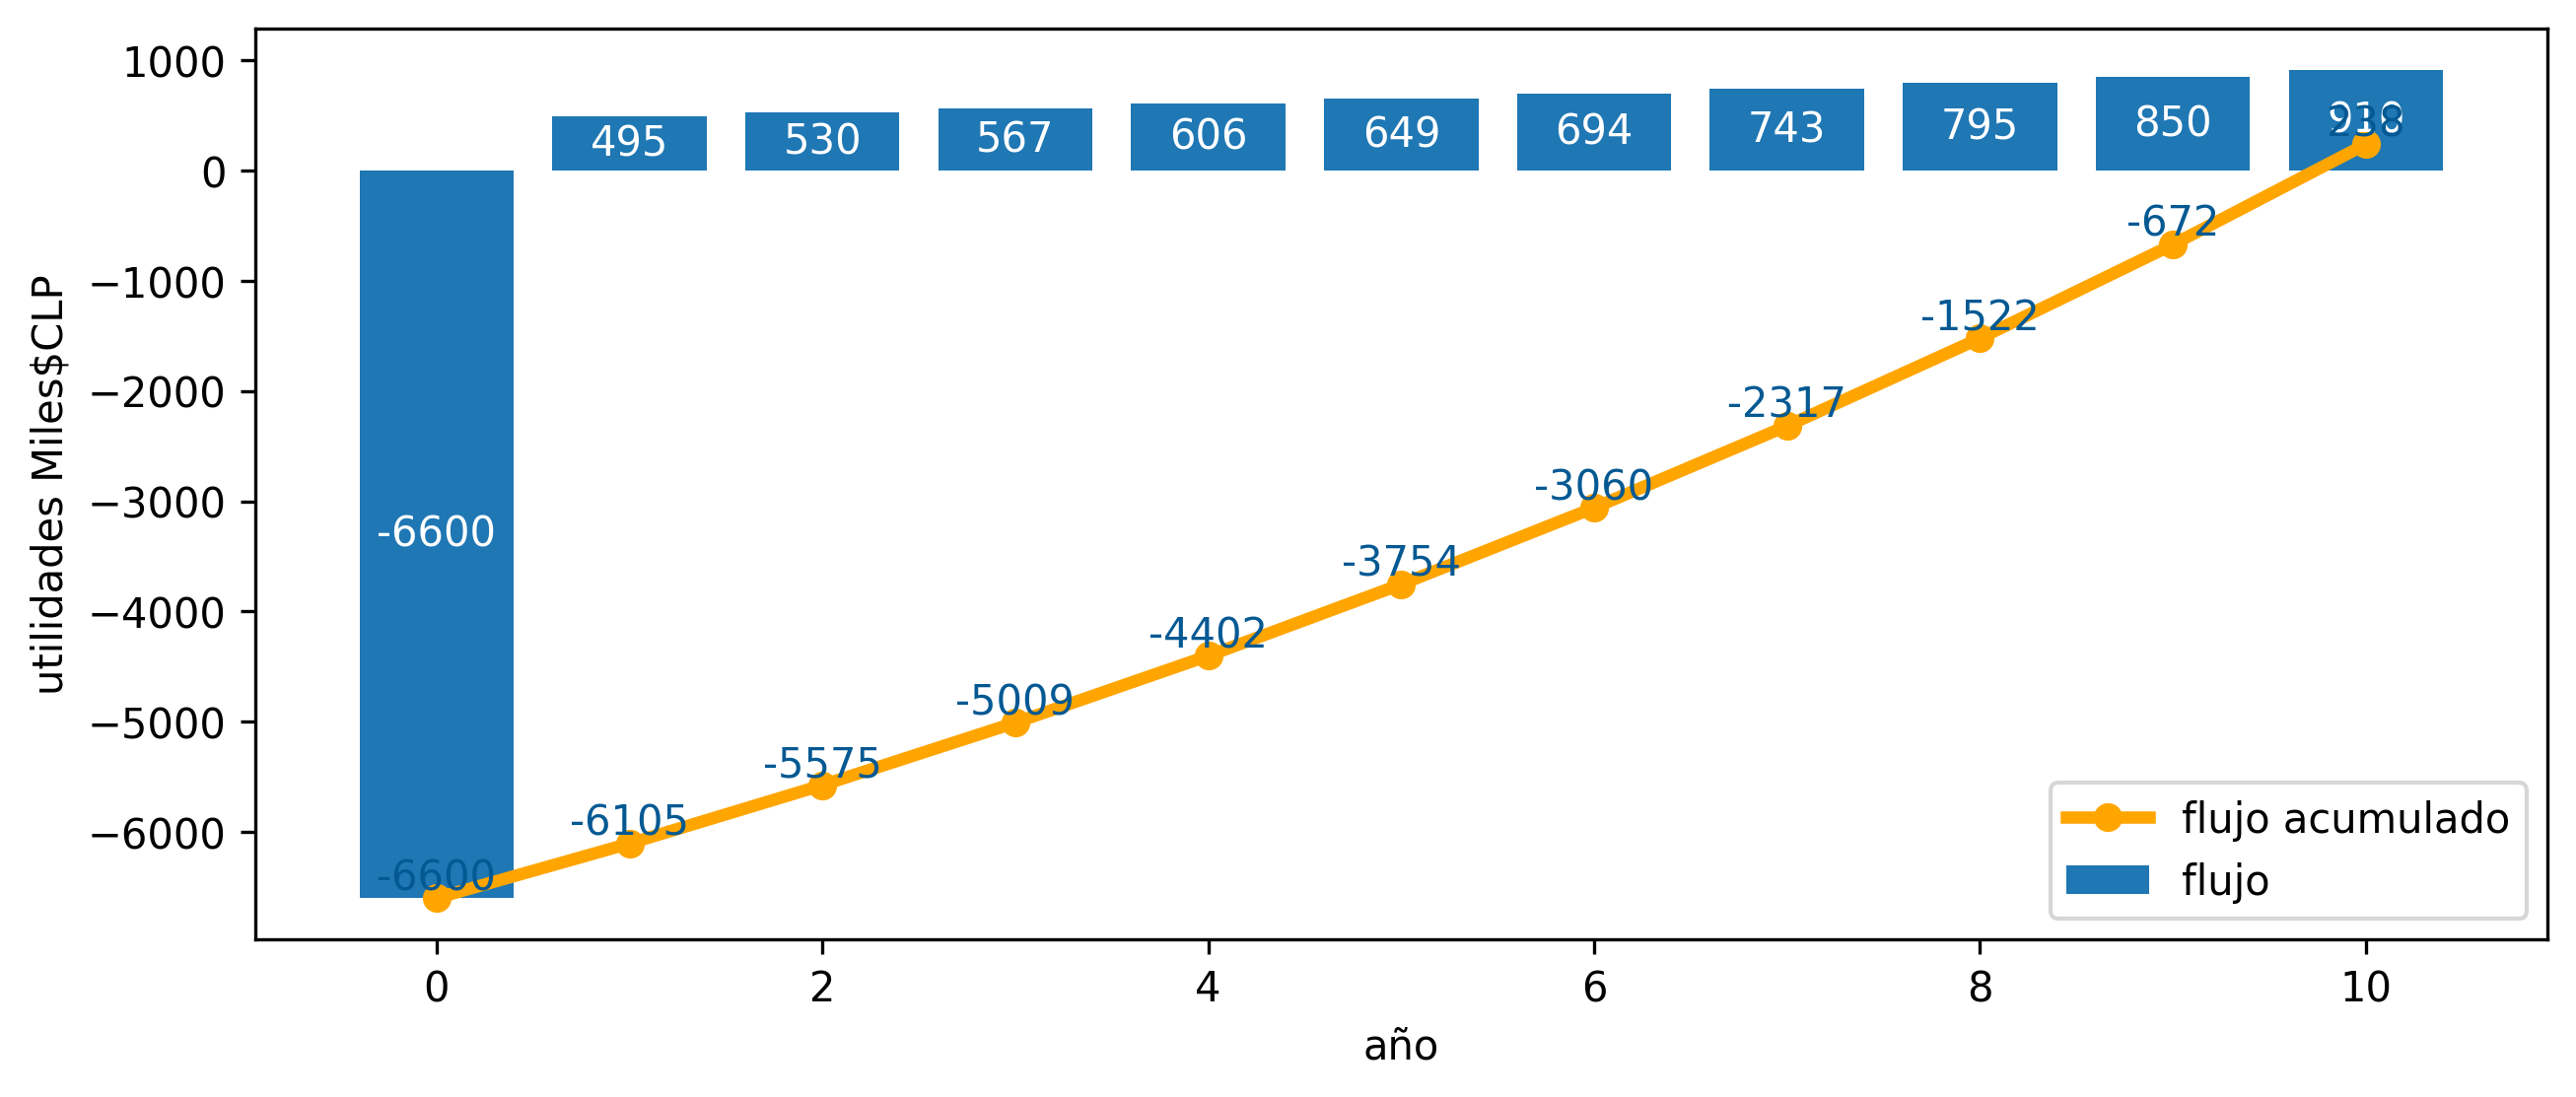

In [11]:
#dep
from models.plotter import plotter
plotter(project,PATH)

In [12]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
]

for plot in plot_list:
    memory_report.replace_pic(plot,PATH+f'{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux


In [13]:
memory_report.save(PATH+f"reporte_memoria_calculo.docx")
bidding_report.save(PATH+f"reporte_pliegos_técnicos.docx")

PermissionError: [Errno 13] Permission denied: 'build/r_san_PSR Leyda/reporte_memoria_calculo.docx'